In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from networks import fcn_isotropic
import scipy
import torch.nn as nn

np.random.seed(42)
torch.manual_seed(42)

In [2]:
data = np.load(r'/Users/jaworskj/Desktop/Pulse_data_sample/2025_10_24_sample_100x100x5mm_no_defect_isotropic.npz', allow_pickle=True)

In [3]:
data['meta']

array([['time', '24/10/2025 20:16:11'],
       ['lamp_power', '200'],
       ['lamp_power_units', 'W'],
       ['T1', '4'],
       ['T1_units', 'frames'],
       ['T2', '300'],
       ['T2_units', 'frames'],
       ['T3', '3000'],
       ['T3_units', 'frames'],
       ['fps', '300.0'],
       ['fps_units', 'frames/s'],
       ['height', '512'],
       ['height_units', 'pixels'],
       ['width', '512'],
       ['width_units', 'pixels'],
       ['sequence_length', '3304'],
       ['sequence_length_units', 'frames'],
       ['working_distance', '200.0'],
       ['working_distance_units', 'mm'],
       ['thickness', '0.005'],
       ['thickness_units', 'm'],
       ['size_X', '0.1'],
       ['size_X_units', 'm'],
       ['size_Y', '0.1'],
       ['size_Y_units', 'm'],
       ['thermal_conductivity', '2.0'],
       ['thermal_conductivity_units', 'W/(m·K)'],
       ['density', '1600.0'],
       ['density_units', 'kg/m^3'],
       ['specific_heat', '700.0'],
       ['specific_heat_units', 'J

In [4]:
data['data'][304:,:,:].shape

(3000, 512, 512)

In [5]:
print(f"There is: {512*512} of initial conditions, and there is {(4*512)*3000} boundary conditions") 

There is: 262144 of initial conditions, and there is 6144000 boundary conditions


In [6]:
T,H,W=data['data'].shape
H_center=H//2
W_center=W//2

Text(0.5, 1.0, 'Cooling phase')

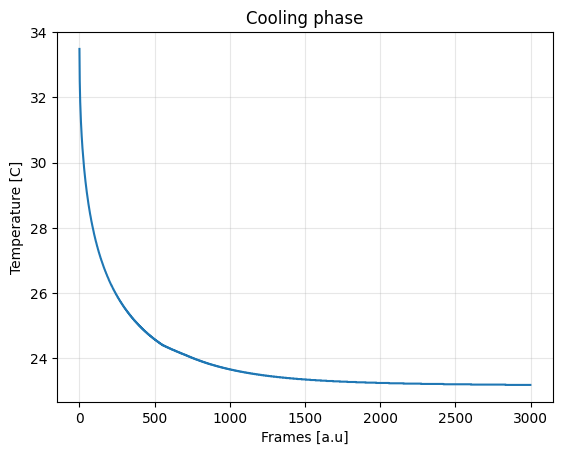

In [7]:
plt.plot(data['data'][304:,H_center,W_center])
plt.ylabel('Temperature [C]')
plt.xlabel('Frames [a.u]')
plt.grid(alpha=0.3)
plt.title('Cooling phase')

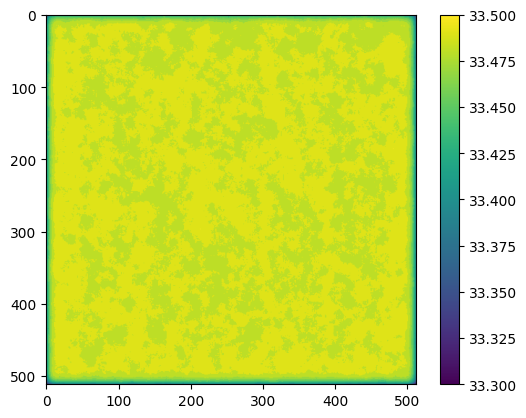

In [8]:
plt.imshow(data['data'][304,:,:])
plt.colorbar()

In [9]:
data=data['data'][304:,:,:]+275.15
data=torch.from_numpy(data).float()

In [18]:
data[0]

tensor([[308.4500, 308.4700, 308.4900,  ..., 308.4900, 308.4700, 308.4500],
        [308.4700, 308.4900, 308.5100,  ..., 308.5100, 308.4900, 308.4700],
        [308.4900, 308.5100, 308.5200,  ..., 308.5200, 308.5100, 308.4900],
        ...,
        [308.4900, 308.5100, 308.5200,  ..., 308.5300, 308.5100, 308.4900],
        [308.4700, 308.4900, 308.5100,  ..., 308.5100, 308.5000, 308.4800],
        [308.4500, 308.4700, 308.4900,  ..., 308.4900, 308.4800, 308.4600]])

In [11]:
from scipy.stats import qmc

In [12]:
sampler = qmc.LatinHypercube(d=2)  # 2D sample space
samples = sampler.random(n=H**2)   # number of samples
samples = torch.tensor(samples, dtype=torch.float32)

In [13]:
samples.size()

torch.Size([262144, 2])

In [14]:
I_con_dom=data[0,:,:]
I_con_dom.size()

torch.Size([512, 512])

In [15]:
I_con_dom=I_con_dom.flatten().unsqueeze(-1)
I_con_dom.size()

torch.Size([262144, 1])

In [63]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from networks import fcn_isotropic
from helper_function import NormalizeData, DomainDataset, DataPointsDataset
from torch.utils.data import DataLoader
from scipy.stats import qmc

device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# Training parameters
#--------------------------------------------------------------------/
N_epoch=50000
lr=1e-3
batch_size=5000
N_samples = 100000 
#--------------------------------------------------------------------/

# Physical parameters of the sample
#--------------------------------------------------------------------/
sampling_time=300.0 # FPS camera recording
height=0.1 # [m] heigh of the sample
width=0.1 # [m] width of the sample 
thickness=0.005 # [m] thickness of sample

target_conductivity=2.0 # [W/(m*K)] Target conductivity of isotropic case
Cp=700.0 # [J/(kg*K)] Specific heat of the material
q=1600.0 # [kg/m^3] Density of the material
#--------------------------------------------------------------------/

# Data preprocessing
#--------------------------------------------------------------------/
data = np.load(r'/Users/jaworskj/Desktop/Pulse_data_sample/2025_10_24_sample_100x100x5mm_no_defect_isotropic.npz', allow_pickle=True)

# Trimming the data and converting them to Kelvins
data=data['data'][304:,:,:]+275.15
data=torch.from_numpy(data).float()

T_samples,Y_samples,X_samples=data.shape

# Defining the domain
t = torch.linspace(0, T_samples/sampling_time, T_samples) # [0,T_max]
y = torch.linspace(0, height, Y_samples) # [0, H]
x = torch.linspace(0, width, X_samples) # [0, W]

# Max scalling the domain to [0 - 1] regions
t_norm,t_scale=NormalizeData(t)
y_norm,y_scale=NormalizeData(y)
x_norm,x_scale=NormalizeData(x)

t_grid, y_grid, x_grid = torch.meshgrid(t_norm, y_norm, x_norm, indexing='ij')

data_coordis = torch.stack([t_grid.reshape(-1,1),
                              y_grid.reshape(-1,1),
                                x_grid.reshape(-1,1)], dim=1).squeeze(-1)

y=data.flatten().unsqueeze(-1)


# Subsampling the dataset for data loss
idx = torch.randperm(data_coordis.shape[0])[:N_samples]
X_train = data_coordis[idx]
y_train = y[idx]

In [64]:
X_train.dtype

torch.float32

In [60]:
I_temp=data[0,:,:]
I_temp=I_temp.flatten().unsqueeze(-1)
I_temp.dtype

torch.float32

In [57]:
y_grid,x_grid=torch.meshgrid(y_norm,x_norm,indexing='ij')

I_coordis=torch.stack([y_grid.reshape(-1,1),
                       x_grid.reshape(-1,1)],dim=1).squeeze(-1)

initial_time=torch.zeros(I_coordis.size(0),1)
Initial_position=torch.cat([initial_time,I_coordis],dim=1)

Initial_position.size()

torch.Size([262144, 3])

In [61]:
Initial_position.dtype

torch.float32

In [65]:
data_coordis

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0020],
        [0.0000, 0.0000, 0.0039],
        ...,
        [1.0000, 1.0000, 0.9961],
        [1.0000, 1.0000, 0.9980],
        [1.0000, 1.0000, 1.0000]])

In [69]:
y

tensor([[308.4500],
        [308.4700],
        [308.4900],
        ...,
        [298.0800],
        [298.0800],
        [298.0700]])

In [78]:
# --- Masks for boundaries (exact equality) ---
mask_y = ((data_coordis[:, 1] == 0) | (data_coordis[:, 1] == 1)) & (data_coordis[:,0] != 0)  # y = 0 or 1 and t not 0
mask_x = ((data_coordis[:, 2] == 0) | (data_coordis[:, 2] == 1)) & (data_coordis[:,0] != 0)    # x = 0 or 1 and t not 0
mask_t = (data_coordis[:, 0] == 1) 

In [79]:
mask_bc = mask_y | mask_x | mask_t

In [80]:
coords_bc = data_coordis[mask_bc]
values_bc = y[mask_bc]

In [82]:
coords_bc.size()

torch.Size([6390056, 3])

In [83]:
values_bc.size()

torch.Size([6390056, 1])